In [34]:
import re
import nltk
from nltk.corpus import stopwords
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from yellowbrick.cluster import KElbowVisualizer

In [35]:
STOPWORDS = list(set(stopwords.words('english')))

In [36]:
def sanitize_text(text: str, remove_stopwords: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces

    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords

    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in STOPWORDS]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [37]:
with open("./devs.txt", "r") as f:
    devs = f.read().splitlines()

In [38]:
to_remove = ["junior", "senior", "stage", "sr"]
STOPWORDS.extend(to_remove)

In [39]:
def normalize_role(text):
    roles_to_normalize = [("front end", "frontend"), ("back end", "backend")]
    for wrong, right in roles_to_normalize:
        if wrong in text:
            return right + " " + text[len(wrong) + 1:]
        else:
            return text

In [40]:
cleaned_jobs = [sanitize_text(job, remove_stopwords=True) for job in devs]
cleaned_roles = [normalize_role(job) for job in cleaned_jobs]

In [65]:
def run(vectorizer, cleaned_jobs, n_clusters):
    X = vectorizer.fit_transform(cleaned_jobs).toarray()
    voc = vectorizer.get_feature_names()
    kmeans = KMeans(n_clusters=n_clusters).fit(X)
    clusters = kmeans.predict(X)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(X)

    centers = pca.transform(kmeans.cluster_centers_)
    
    pca_1, pca_2 = reduced[:, 0], reduced[:, 1]
    df = pd.concat([pd.Series(pca_1, name="PCA1"), \
        pd.Series(pca_2, name="PCA2"), \
            pd.Series(clusters, name="cluster")], axis=1)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df, x="PCA1", y="PCA2", hue="cluster", palette="coolwarm")

        

    # print("Top terms per cluster:")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    for i, (_x, _y) in enumerate(centers):
        # print("Cluster %d:" % i),
        for ind in order_centroids[i, :1]:
            # print(' %s' % voc[ind])
            plt.text(_x, _y, f"{i}_{voc[ind]}", horizontalalignment='left', size='medium', color='black')


    plt.show()

In [66]:
# vecs = [CountVectorizer(ngram_range=(2, 3)), TfidfVectorizer(ngram_range=(2, 3))]
vecs = [TfidfVectorizer(ngram_range=(2, 3))]

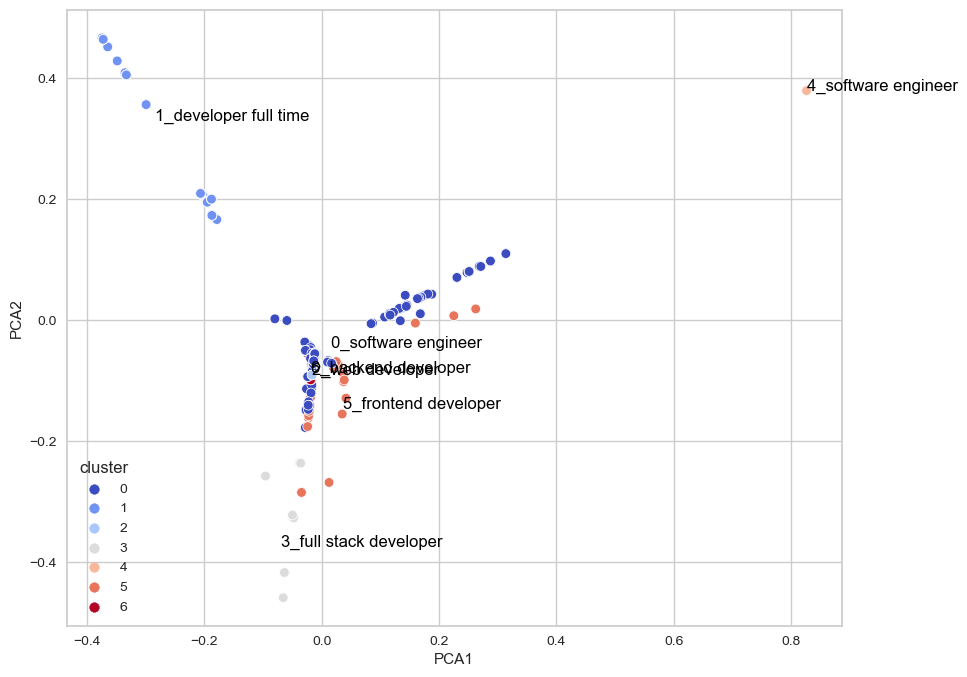

In [67]:
# for vec in vecs:
#     print(f"VEC: {vec.__class__.__name__}")
    # run(vec, cleaned_roles, 10)
run(TfidfVectorizer(ngram_range=(2, 3)), cleaned_roles, 7)